<a href="https://colab.research.google.com/github/georgezero/rsna25-deid-using-chatgpt-llms/blob/update-nootebooks-colab/01_image_anonymization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quick start
- Run the `pip install` cell.
- Get a free API key from [Google AI Studio](https://aistudio.google.com/app/apikey).
- Set your `GOOGLE_API_KEY` in the code below.

In [ ]:
# Install dependencies
%pip install -q -U google-generativeai pillow==11.3.0 numpy ipywidgets pandas==2.2.2

You will need to create an API key. Click the link for a quick tutorial: [Tutorial](https://drive.google.com/file/d/1fGoSsapol9JY9oqu-UulLJfMm-v2egWC/view?usp=drive_link)

In [ ]:
import os
from io import StringIO
import google.generativeai as genai
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd


GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY") or "PASTE_YOUR_KEY_HERE" # Paste your Google API Key here

if GOOGLE_API_KEY == "PASTE_YOUR_KEY_HERE":
    print("⚠️ Please paste your Google API Key in the variable above.")
else:
    genai.configure(api_key=GOOGLE_API_KEY)
    print("✅ Gemini API configured")

✅ Gemini API configured


## Create a mock medical image with burnt-in PHI
We will generate a simple image that simulates a medical scan (like an X-ray or Ultrasound) with patient details burned into the pixels.

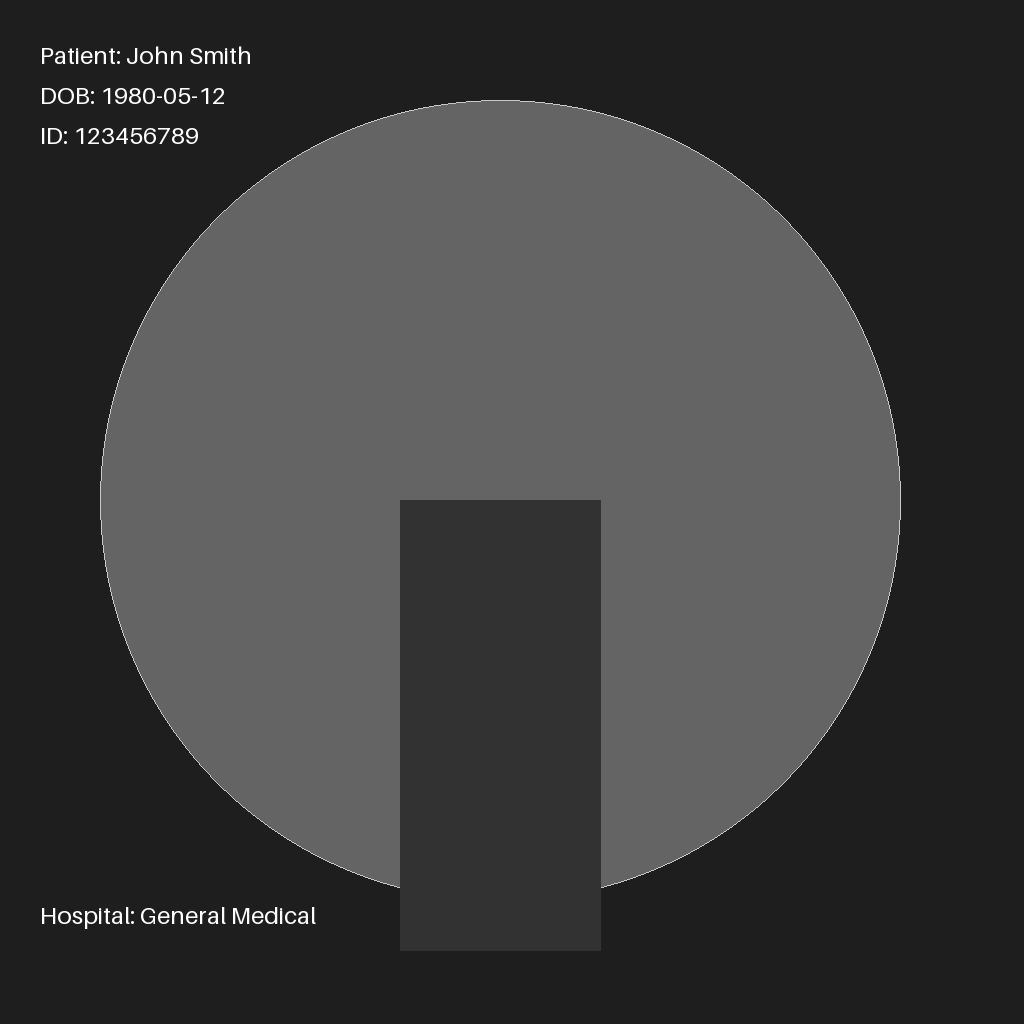

In [ ]:
def create_mock_image():
    # Create a dark background (simulating X-ray background)
    img = Image.new('RGB', (1024, 1024), color = (30, 30, 30))
    d = ImageDraw.Draw(img)

    # Draw some "anatomy" (random shapes)
    d.ellipse([100, 100, 900, 900], fill=(100, 100, 100), outline=(200, 200, 200))
    d.rectangle([400, 500, 600, 950], fill=(50, 50, 50))

    # Burn in some PHI text
    # In real DICOMs, this often happens in Ultrasound or secondary captures

    text_color = (255, 255, 255)
    d.text((40, 40), "Patient: John Smith", fill=text_color, font_size=24)
    d.text((40, 80), "DOB: 1980-05-12", fill=text_color, font_size=24)
    d.text((40, 120), "ID: 123456789", fill=text_color, font_size=24)
    d.text((40, 900), "Hospital: General Medical", fill=text_color, font_size=24)

    return img

mock_image = create_mock_image()
display(mock_image)

## Analyze the image with Gemini Flash Lite
We will ask the model to identify any text in the image and flag potential PHI.

In [ ]:
model = genai.GenerativeModel('models/gemini-flash-lite-latest')
# or, if you want to use the latest SOTA model
# But limited availability on free tier
# model = genai.GenerativeModel('models/gemini-3-pro-preview')

prompt = """
Analyze this medical image.
1. Transcribe any text visible in the image.
2. Identify which parts of the text are Protected Health Information (PHI).
3. Provide a risk assessment (Low/Medium/High) for this image regarding patient privacy.

Return a markdown formatted tabular response that contains the following columns:
- PHI type (e.g., Name, Date of Birth, ID Number, etc.)
- Transcribed Text
- Bbox Coordinates (in format: [(x1, y1), (x2, y2)])
- Risk Level (Low/Medium/High)

format your response as a markdown table like this:
| PHI type.       | Text              | Bbox Coordinates     |  Risk Level     |
|-----------------|-------------------|----------------------|-----------------|
| [Type of PHI]   | [Transcribed Text]| [(x1, y1), (x2, y2)] | low/medium/high |

Be sure to include exact bbox coordinates with some additional padding for each detected PHI element.
"""

response = model.generate_content([prompt, mock_image])
print(response.text)

The analysis of the image for Protected Health Information (PHI) is as follows:

| PHI type | Text | Bbox Coordinates | Risk Level |
|---|---|---|---|
| Name | Patient: John Smith | [(46, 39), (214, 60)] | High |
| Date of Birth | DOB: 1980-05-12 | [(48, 71), (219, 90)] | High |
| ID Number | ID: 123456789 | [(48, 104), (211, 123)] | High |
| Facility Name | Hospital: General Medical | [(33, 889), (304, 908)] | Medium |

**Summary of Risk Assessment:**

*   **Name, DOB, ID Number:** These are direct identifiers that constitute high-risk PHI, as they can be used to uniquely identify an individual.
*   **Hospital Name:** While the hospital name alone might not be enough to identify the patient without the direct identifiers, in combination with other medical data (which this image implies is present or linked), it is considered Medium risk PHI as it relates to the provision of healthcare.


let's further look into the response and extract the table in markdown format.

In [ ]:
def extract_table_from_response(response_text):
    lines = response_text.split('\n')
    table_lines = []
    in_table = False
    for line in lines:
        if line.strip().startswith('|'):
            in_table = True
            table_lines.append(line)
        elif in_table:
            break
    return '\n'.join(table_lines)

In [ ]:
def convert_markdown_table_to_dataframe(markdown_table):
    table_io = StringIO(markdown_table)
    df = pd.read_csv(table_io, sep='|', skipinitialspace=True, engine='python')

    # Drop empty columns created by leading/trailing pipes
    df = df.dropna(axis=1, how='all')

    # Remove the separator row (e.g., "---|---|---")
    # We check if the first row contains dashes
    if len(df) > 0 and df.iloc[0].astype(str).str.contains('---').any():
        df = df.iloc[1:]

    # Clean up whitespace in column names and data
    df.columns = df.columns.str.strip()
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    # Reset the index
    df = df.reset_index(drop=True)

    return df

In [ ]:

table_md = extract_table_from_response(response.text)
df = convert_markdown_table_to_dataframe(table_md)
display(df)

,PHI type,Text,Bbox Coordinates,Risk Level
0,Name,Patient: John Smith,"[(46, 39), (214, 60)]",High
1,Date of Birth,DOB: 1980-05-12,"[(48, 71), (219, 90)]",High
2,ID Number,ID: 123456789,"[(48, 104), (211, 123)]",High
3,Facility Name,Hospital: General Medical,"[(33, 889), (304, 908)]",Medium
